# Hierarchical Clustering 

In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Each row in the dataset corresponds to one of the N=62 bottlenose dolphins in the studied network. We have three
sources of information:

A set of features characterising each individual. This information is given as a N x p feature matrix F,
where N=62 samples with p=32 features capturing different traits of the dolphins.

The social network of associations between the individual dolphins. The N=62 nodes of the graph are
the individuals and the E=159 edges correspond to the frequent associations between them. This
information is given as a N x N adjacency matrix, A.
    
A table listing the dolphin names ordered according to the rows of the feature and adjacency matrices.

In [5]:
# Load dolphin data

# Adjacency matrix
A = np.load("dolphins_A_62x62.npy")

# Feature matrix
F = np.load("dolphins_F_62x32.npy")
names = pd.read_csv("dolphin_names.csv")

Using only NumPy/SciPy, we employ hierarchical clustering to cluster the feature matrix F. We use average linkage and take Euclidean distance as the distance. 

First we create a function that computes the euclidean distance between each two point in the input data.

In [6]:
def pairwise_distances(points):
    '''
    Input:
      points: A numpy array of points having the shape (N, D), 
      where N is the number of points and D is the number of features.
    Output:
      A numpy array with shape (N, N) such that the element (i, j) is the 
      computed distance between i-th point and j-th point in X.
    '''
    N, D = points.shape
    distance = np.empty((N, N))
    
    # distance matrix will be symmetric, so avoid redundant computations.
    for i in range(N):
        distance[i, i] = 0
        for j in range(i + 1, N):
            d = np.sqrt(np.power(points[i, :] - points[j, :], 2).sum())
            distance[i, j] = d
            distance[j, i] = d
            
    return distance

In our hierarchical clustering we use average linkage.

In [7]:
def average_linkage(distances, cluster_assignment, i, j):
    """
    This function computes the average linkage value between two clusters.
    Input:
      distances: A numpy array of pair-wise distances for the given points.
      cluster_assignment: A 1-D numpy array that assigns a cluster id for every point.
      i: the first cluster id.
      j: the second cluster id.
    Output:
      The average distance between the two given clusters.
    """

    # Select the point indices of the first cluster.
    points_i = np.argwhere(cluster_assignment == i)

    # Select the point indices of the second cluster.
    points_j = np.argwhere(cluster_assignment == j)

    # Form a cartesian product between the indices in i and indices in j.
    pairs = np.array([[element_i.item(), element_j.item()]  for element_i in points_i for element_j in points_j])

    # Select the pair distances between the points in the two clusters from the distances matrix.
    pairs_distance = distances[pairs[:, 0], pairs[:, 1]]

    # Return the average
    return pairs_distance.mean()

In [8]:
def hierarchical_clustering(points, distances, linkage):
    '''
    The hierarchical clustering algorithm start with every point as a single cluster and 
    each iteration merges two clusters into one. We may wish to store all the 
    intermediate clustering results with respect to the number of clusters left.

    Input:
     points: A numpy array of points having the shape (N, D), where N is the number of points and D is the number of features.
     distances: A numpy array with shape (N, N) such that the element (i, j) is the computed distance between i-th point and j-th point in X.
     linkage: A linkage function from the above to call to compute the linkage values between two clusters.

    Output:
     A numpy array of shape (N, N) of which each row stores the clustering assignment at each level.
     The second row, i.e. assignments[1, :], represents the highest level of clustering where all columns have the same index value.
     The third row, i.e. assignments[2, :], represents all the points assigned into two cluster indices.
     The last row, i.e. assignments[N - 1, :], represents the points assigned into N - 1 cluster indices.
    '''

    N, D = points.shape
    assignments = np.zeros((N, N))
    
    # Begin with every point is its own cluster
    current_assignment = np.arange(N)
    
    # The id to be assigned for the next merged cluster
    next_cluster_id = N
    
    # Begin from level (N - 1) to level 1
    for level in range(N - 1, 0, -1):
        cluster_ids = np.unique(current_assignment)
        
        min_d = np.inf
        
        # Initialize the cluster ids to be merged in this iteration.
        cluster_a, cluster_b = (-1, -1) 
        
        # Now find the two clusters that have the minimum distance in between.
        for i in range(cluster_ids.size):
            for j in range(i + 1, cluster_ids.size):
                cluster_i = cluster_ids[i]
                cluster_j = cluster_ids[j]
                d = linkage(distances, current_assignment, cluster_i, cluster_j)
                if d < min_d:
                    min_d = d
                    cluster_a, cluster_b = (cluster_i, cluster_j)
                    
        
        # Merge the two clusters
        current_assignment[(current_assignment == cluster_a) | (current_assignment == cluster_b)] = next_cluster_id
        next_cluster_id += 1
        # Store the current cluster assignment into the assignments array.
        assignments[level, :] = current_assignment
        
    return assignments

Now we use our function on the feature matrix $F$.

In [9]:
# Compute distances
distances = pairwise_distances(F)

clustering_assignments = hierarchical_clustering(F, distances, average_linkage)

We now report our sequence of clusters from finest to coarsest, i.e. we start with the row having $61$ clusters ($62$ clusters is trivial) and end with the row where everything is in $1$ cluster. 

In [10]:
# Report sequence of clusters from finest to coarsest
for i in range(61, 0, -1):
  print(f"Number of clusters = {i}, \n", "Cluster assignments: \n", clustering_assignments[i])

Number of clusters = 61, 
 Cluster assignments: 
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 62. 23. 24. 25. 26. 27. 28. 29. 30. 62. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61.]
Number of clusters = 60, 
 Cluster assignments: 
 [ 0.  1.  2.  3. 63.  5.  6.  7.  8.  9. 10. 63. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 62. 23. 24. 25. 26. 27. 28. 29. 30. 62. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61.]
Number of clusters = 59, 
 Cluster assignments: 
 [ 0.  1.  2.  3. 63.  5.  6.  7.  8. 64. 10. 63. 12. 64. 14. 15. 16. 17.
 18. 19. 20. 21. 62. 23. 24. 25. 26. 27. 28. 29. 30. 62. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61.]
Number of clusters = 58, 
 Cluster assignments: 
 [ 0.  1.  2.  3. 63. 65. 65.  7.  8. 64. 

Using only NumPy/SciPy, we write a function to calculate the Silhouette Score of a given clustering. The Silhouette Score is a measure of the quality of clustering and is defined as the mean Silhouette Coefficient over all samples, where the Silhouette Coefficient of a given sample is given by:

Silhouette Coefficient = (d_2 - d_1)/max(d_1, d_2)

where d_1 is the average distance between the sample and the points in its cluster, and d_2 is the average distance between the sample and the points in the nearest cluster.

In [12]:
def silhouette_score(labels, distances):
  '''
  Compute the silhouette score for the given label assignments using
  the precomputed distances between the points.
  Input:
    labels: array of cluster assignments
    d: ndarray of distances between pairs of points
  Output:
   the average silhouette score
  '''

  d1s = []
  d2s = []

  for i in range(len(labels)):
    # Compute the points in the smae cluster as the current data point
    neighbours = np.where(labels == labels[i])[0]

    # If we have a cluster witha single point
    if len(neighbours) == 0:
      d1 = 0.0

    # Compute the average distance between the point and the points in its cluster
    d1 = np.mean([distances[i,j] for j in neighbours if not i == j])
    d1s.append(d1)

    # Compute the mean distances from the point to each other cluster
    centroid = labels[i]
    d2_means = []
    for cur_label in set(labels):
      if not cur_label == centroid:
        d2_means.append(np.mean([distances[i, j] for j in np.where(labels == cur_label)[0]]))

    # Take the average distance to the nearest cluster
    d2 = np.min(d2_means)
    d2s.append(d2)

  d1s = np.array(d1s)
  d2s = np.array(d2s)

  silhouette_scores = (d2s - d1s) / np.maximum(d1s, d2s)
  silhouette_scores = np.nan_to_num(silhouette_scores)

  return np.mean(silhouette_scores)

Now we loop over the cluster assignments from finest to coarsest (i.e. from $61$ to $2$ clusters) and plot the silhouette score for each number of clusters.

In [14]:
# Compute the silhouette scores
silhouette_scores = []

for i in range(61, 1, -1):
  silhouette_scores.append(silhouette_score(clustering_assignments[i], distances))

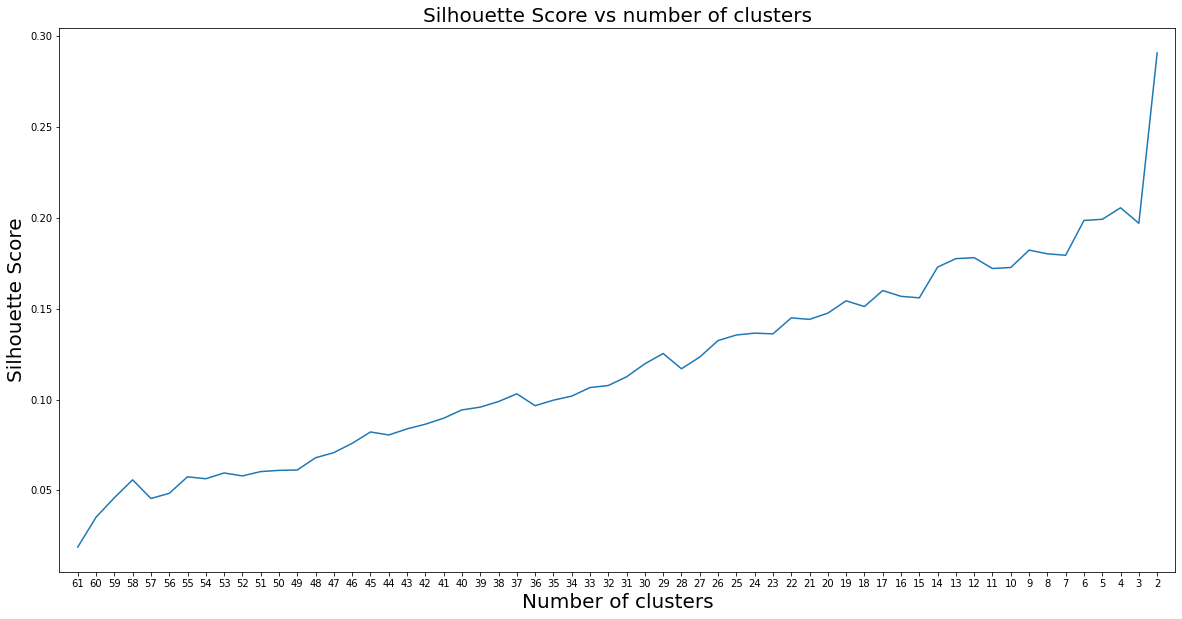

In [15]:
# Plot Silhouette score for each number of clusters
plt.figure(figsize=(20, 10))
plt.plot(np.arange(61, 1, -1), silhouette_scores)
plt.title("Silhouette Score vs number of clusters", size=20)
plt.xlabel("Number of clusters", size=20)
plt.ylabel("Silhouette Score", size=20)
plt.xlim(62, 1)
plt.xticks(np.arange(61, 1, -1))
plt.show()

We can see that the silhouette score is maximised for $2$ clusters, so we deduce that $2$ is the optimal level. 

# Graph-based analysis

Now we will analyse the dolphin social network, i.e. the graph of frequent associations encoded
by the adjacency matrix A.

In [16]:
# Import modules
import numpy as np
import networkx as nx
import pandas as pd
from scipy.sparse import linalg
import matplotlib.pyplot as plt
from matplotlib import colors

First we construct the Laplacian of our graph, given by
\begin{equation}
L = D - A,
\end{equation}
where $D$ is our diagonal matrix of node degrees and $A$ is our adjacency matrix.

In [17]:
# define diagonal matrix of node degrees
weighted_degree = A.sum(axis=1) 

# create diagonal matrix of degree
D = np.diag(weighted_degree) 

# Compute the Laplacian
L = D-A

Now we compute the normalized Laplacian
\begin{equation}
L =  I -  D^{-1/2}A D^{-1/2},
\end{equation}
and then we compute its two smallest eigenvalues and corresponding eigenvectors.

In [18]:
# computing inverse square root vector of degree
weighted_degree_sqrt = 1.0 / np.sqrt(weighted_degree)

# set a diagonal matrix of the inverse square root of degree
D_inv_sqrt = np.diag(weighted_degree_sqrt)

# define the normalised Laplacian
L_normalized = np.eye(A.shape[0]) - D_inv_sqrt.dot(A.dot(D_inv_sqrt))

# return the smallest magnitude eigenvectors and eigenvalues
eigenvals, eigenvecs = linalg.eigsh(L_normalized, 2, which="SM", return_eigenvectors=True)

# printing the eigenvalues
print(f'The smallest eigenalue is: {eigenvals[0]}')
print(f'The second smallest eigenalue is: {eigenvals[1]}')

The smallest eigenalue is: 2.822991406609132e-16
The second smallest eigenalue is: 0.03952455375743446


Now we want to partition our graph into two subgraphs $S_1$ and $S_2$. We do this by minimising the cost function
\begin{equation}
C = \frac12 \sum_{i \in S_1, j \in S_2} A_{ij}.
\end{equation}
This is minimised by
\begin{equation}
C^* = \lambda \frac{n_1 n_2}{N},
\end{equation}
where $n_1$ and $n_2$ are the number of nodes in each of the two subgraphs, and $\lambda$ is an eigenvalue of the normalized Laplacian. So we want $\lambda$ to be the smallest possible eigenvalue. The smallest eigenvalue $\lambda_1 = 0$ with eigenvector $\boldsymbol 1$ cannot be the solution we look for, so we take the second smallest eigenvalue $\lambda_2$, i.e. the algebraic connectivity. 

As $\lambda_2 \approx 0.04$, which is quite small, we can deduce that the cost of splitting the graph into two subgraphs is low, so there exists a good bipartition of the graph, which is given by the eigenvector corresponding to $\lambda_2$. 

Now we compute the spectral partition of the graph into two sets of nodes by using the second eigenvector, where the nodes are split into two groups defined by the signs of the elements of the eigenvector. 

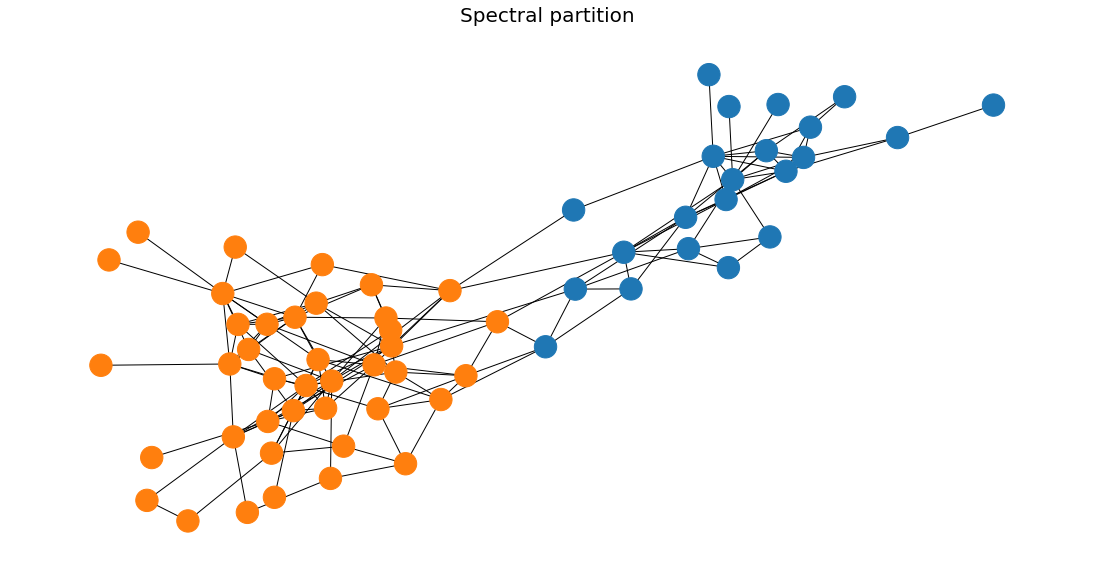

In [19]:
# Produce graph from adjacency matrix
graph = nx.Graph(A)

# extract the second eigenvector
second_eigenvector = eigenvecs[:,1]

# define a partition and binarize the negative and positive eigenvector values
spectral_partition = second_eigenvector
spectral_partition[spectral_partition < 0] = -1
spectral_partition[spectral_partition > 0] = 1

# draw the spectral partition
plt.figure(figsize=(15,7.5))
nx.draw(graph, 
        node_size=500, 
        node_color=spectral_partition, 
        cmap=colors.ListedColormap(['C0', 'C1']))
plt.title("Spectral partition", size=20)
plt.show()

The bipartition produced looks reasonable and intuitive.

Now we will discuss the concept of centrality for our graph, by considering the three measures:


1. PageRank centrality - for a given graph with adjacency matrix $A$, the PageRank centrality of each node is then given by the elements of the vector obtained by solving for $c_{PR}$ in 
\begin{equation}
  c_{PR} = 0.85 (A D^{-1}) c_{PR} + \frac{0.15}{N} \boldsymbol 1. 
\end{equation}
2. Degree centrality - we use the degree of each node
3. Eigenvector centrality - here we want the eigenvector correspoding to the largest eigenvalue of $A$

We start by computing the PageRank centrality of our graph

In [20]:
# Compute Page Rank for each node
N = A.shape[0]
D_inv = np.linalg.inv(D)
c_PR = np.linalg.solve(np.identity(N) - 0.85 * A @ D_inv, 0.15 / N * np.ones(N))

# Print the Page Rank centralities
print("Page Rank centralities: \n", c_PR)

Page Rank centralities: 
 [0.01696539 0.02465072 0.01333808 0.00962906 0.0050798  0.01442805
 0.02005363 0.01564303 0.0170983  0.02345848 0.0151084  0.0050798
 0.00483532 0.02615688 0.03214449 0.01988308 0.01662682 0.03172814
 0.01939555 0.0129282  0.02464092 0.01693899 0.0054159  0.0098635
 0.01690576 0.01150422 0.01121014 0.01713009 0.01484574 0.02645855
 0.0153021  0.0054159  0.01330868 0.02842307 0.01591994 0.00491822
 0.02061339 0.02987534 0.02393924 0.00776475 0.02196637 0.01613757
 0.01761865 0.02169113 0.01283083 0.0295142  0.0088259  0.01733952
 0.0052617  0.00887675 0.01923194 0.03129936 0.01207259 0.00818105
 0.02165088 0.00749417 0.00832625 0.03009537 0.0049629  0.01476792
 0.00619015 0.01103919]


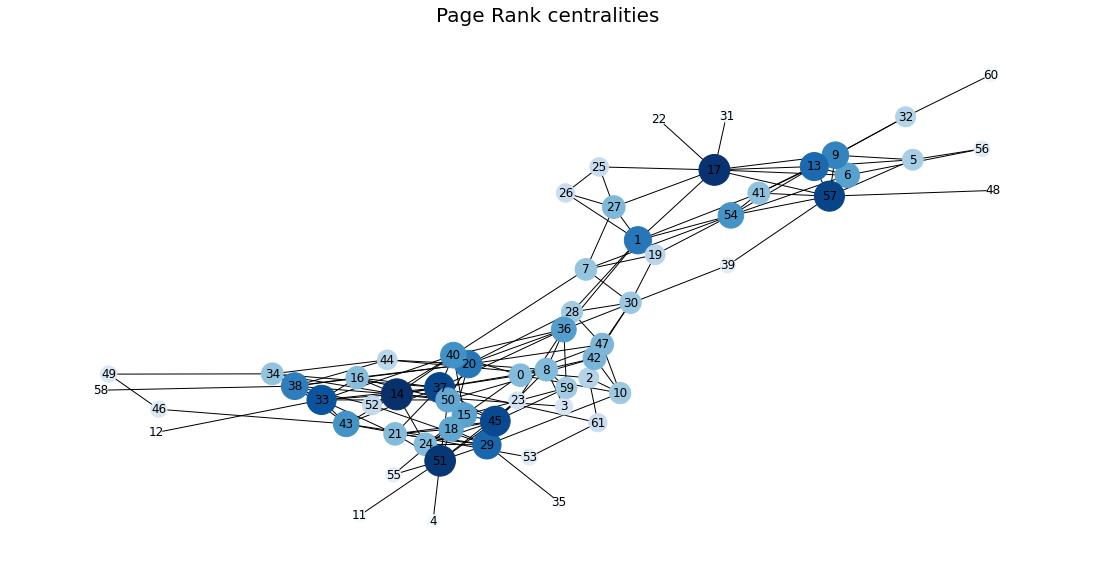

In [21]:
# Draw the graph
plt.figure(figsize=(15,7.5))
nx.draw(graph, 
        node_color=c_PR,
        node_size=c_PR*30000,
        cmap=plt.cm.Blues,
        with_labels=True)
plt.title("Page Rank centralities", size=20)
plt.show()

In [22]:
# Find the 10 nodes with largest Page Rank centralities
nodes_largest_PR = c_PR.argsort()[-10:][::-1]

for node in nodes_largest_PR:
  print(f"Node {node} with name {names.name[node]} has Page Rank centrality {c_PR[node]:.4f}.")

Node 14 with name Grin has Page Rank centrality 0.0321.
Node 17 with name Jet has Page Rank centrality 0.0317.
Node 51 with name Trigger has Page Rank centrality 0.0313.
Node 57 with name Web has Page Rank centrality 0.0301.
Node 37 with name SN4 has Page Rank centrality 0.0299.
Node 45 with name Topless has Page Rank centrality 0.0295.
Node 33 with name Scabs has Page Rank centrality 0.0284.
Node 29 with name Patchback has Page Rank centrality 0.0265.
Node 13 with name Gallatin has Page Rank centrality 0.0262.
Node 1 with name Beescratch has Page Rank centrality 0.0247.


Now we repeat these steps for the degree centrality.

In [23]:
# compute the degrees from the adjacency
c_degree = A.sum(axis=1)

# Print Degree centralities
print("Degree centralities: \n", c_degree)

Degree centralities: 
 [ 6.  8.  4.  3.  1.  4.  6.  5.  6.  7.  5.  1.  1.  8. 12.  7.  6.  9.
  7.  4.  9.  6.  1.  3.  6.  3.  3.  5.  5.  9.  5.  1.  3. 10.  5.  1.
  7. 11.  8.  2.  8.  5.  6.  7.  4. 11.  2.  6.  1.  2.  7. 10.  4.  2.
  7.  2.  2.  9.  1.  5.  1.  3.]


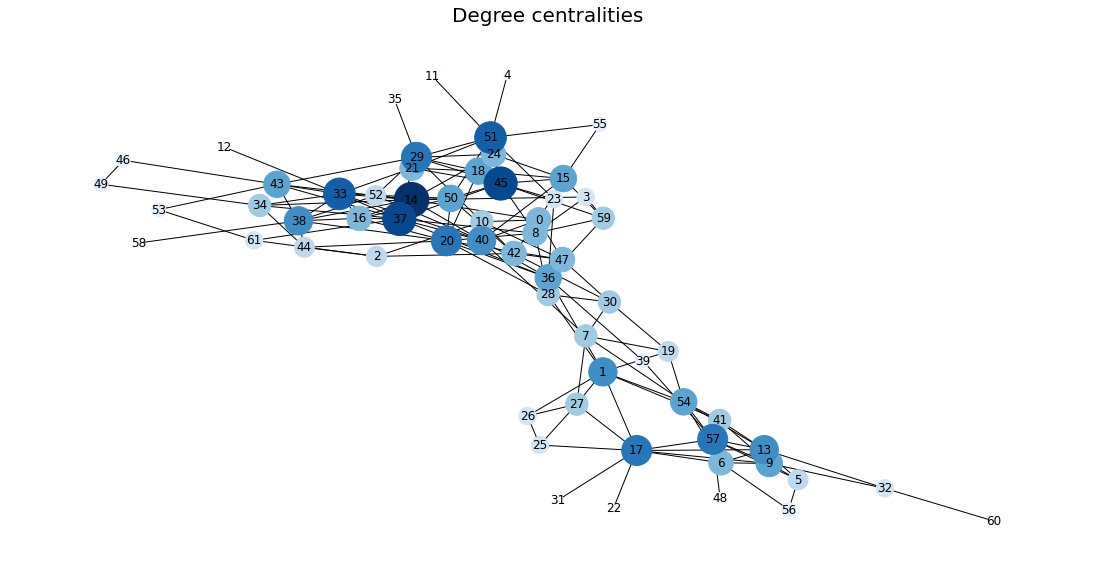

In [24]:
# Draw the graph
plt.figure(figsize=(15,7.5))
nx.draw(graph, 
        node_color=c_degree,
        node_size=c_degree*100,
        cmap=plt.cm.Blues,
        with_labels=True)
plt.title("Degree centralities", size=20)
plt.show()

In [25]:
# Find the 10 nodes with largest Degree centralities
nodes_largest_degree = c_degree.argsort()[-10:][::-1]

for node in nodes_largest_degree:
  print(f"Node {node} with name {names.name[node]} has Degree centrality {int(c_degree[node])}.")

Node 14 with name Grin has Degree centrality 12.
Node 45 with name Topless has Degree centrality 11.
Node 37 with name SN4 has Degree centrality 11.
Node 33 with name Scabs has Degree centrality 10.
Node 51 with name Trigger has Degree centrality 10.
Node 17 with name Jet has Degree centrality 9.
Node 57 with name Web has Degree centrality 9.
Node 29 with name Patchback has Degree centrality 9.
Node 20 with name Kringel has Degree centrality 9.
Node 13 with name Gallatin has Degree centrality 8.


When computing the degree centrality, the importance of a node is simply defined to be its degree. So the more links connected to a node, the higher its degree centrality.

Now we compute the eigenvector centralities.

In [34]:
# compute the eigenvector associated with the largest eigenvalue
eigenvalue, eigenvector = linalg.eigsh(A, 
                                       1,  # number of eigenvalues
                                       which="LM",  # Largest in magnitude
                                       return_eigenvectors=True)
eigenvector = eigenvector.reshape(-1)
# Print Eigenvector centralities
print("Eigenvector centralities: \n", eigenvector)

Eigenvector centralities: 
 [0.12850353 0.04207615 0.03975712 0.07933476 0.02928739 0.00655926
 0.01219126 0.04290099 0.14310214 0.01219738 0.07525347 0.02928739
 0.03907614 0.01500469 0.31578285 0.16417581 0.20799426 0.01751244
 0.20249469 0.02067478 0.18447739 0.2073514  0.00243444 0.08736214
 0.19321357 0.00594605 0.00894396 0.01631719 0.0682235  0.21176308
 0.04074725 0.00243444 0.00385593 0.28109869 0.13882809 0.02943765
 0.1327621  0.30056205 0.19661764 0.02087104 0.20787191 0.01524357
 0.0809501  0.19033934 0.07780237 0.28500522 0.02971651 0.08037062
 0.00241549 0.02342975 0.21769179 0.21068221 0.12956429 0.03368693
 0.02300201 0.05210983 0.00260655 0.01737613 0.02733225 0.11181862
 0.00053602 0.0519914 ]


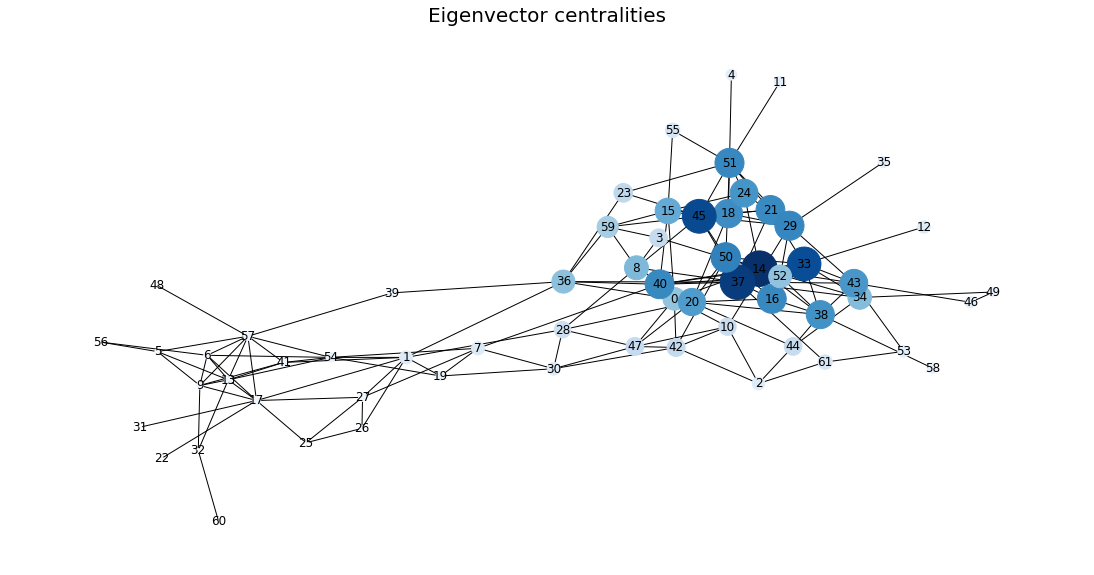

In [35]:
# Draw the graph
plt.figure(figsize=(15,7.5))
nx.draw(graph, 
        node_color=eigenvector,
        node_size=eigenvector*4000,
        cmap=plt.cm.Blues,
        with_labels=True)
plt.title("Eigenvector centralities", size=20)
plt.show()

In [36]:
# Find the 10 nodes with largest Eigenvector centralities
nodes_largest_eigenvector = eigenvector.argsort()[-10:][::-1]

for node in nodes_largest_eigenvector:
  print(f"Node {node} with name {names.name[node]} has Eigenvector centrality {eigenvector[node]:.4f}")

Node 14 with name Grin has Eigenvector centrality 0.3158
Node 37 with name SN4 has Eigenvector centrality 0.3006
Node 45 with name Topless has Eigenvector centrality 0.2850
Node 33 with name Scabs has Eigenvector centrality 0.2811
Node 50 with name TR99 has Eigenvector centrality 0.2177
Node 29 with name Patchback has Eigenvector centrality 0.2118
Node 51 with name Trigger has Eigenvector centrality 0.2107
Node 16 with name Hook has Eigenvector centrality 0.2080
Node 40 with name SN9 has Eigenvector centrality 0.2079
Node 21 with name MN105 has Eigenvector centrality 0.2074


Comparing these ten nodes with largest centralities, we can see than $9$ out of the $10$ nodes with largest degree and Page Rank centrality are the same. Also, $6$ of the nodes are in all three of our lists with ten largest centralities, namely the nodes 
\begin{equation}
14, 37, 45, 33, 29, 51,
\end{equation}
indicating that these nodes are central to our graph and have important properties. Note that node $14$ is the first in terms of all three centralities, suggesting that it is connected to many nodes and a lot of them are important to the network in some sense.

Now we investigate the correlation between the three centralities in a bit more detail.

First we plot three scatter plots visualizing the relationship between each pair of the three centralities and then we have constructed the correlation matrix.

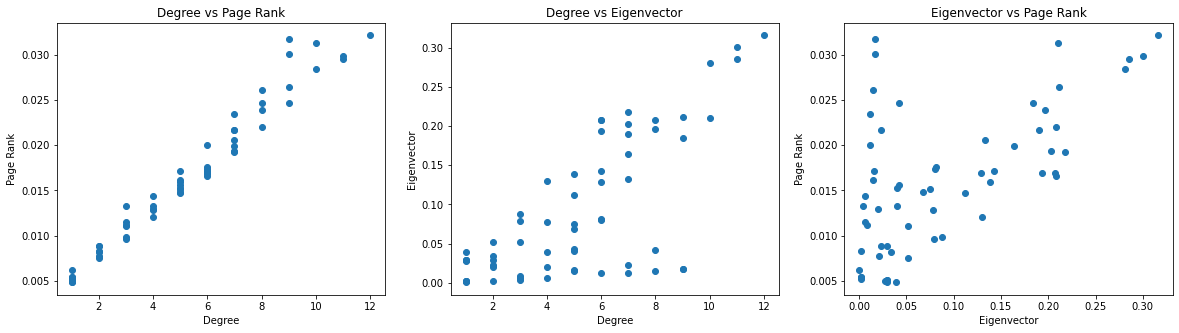

In [37]:
# Plot scatter plots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].scatter(c_degree, c_PR)
axes[0].title.set_text("Degree vs Page Rank")
axes[0].set(xlabel="Degree", ylabel="Page Rank")

axes[1].scatter(c_degree, eigenvector)
axes[1].title.set_text("Degree vs Eigenvector")
axes[1].set(xlabel="Degree", ylabel="Eigenvector")

axes[2].scatter(eigenvector, c_PR)
axes[2].title.set_text("Eigenvector vs Page Rank")
axes[2].set(xlabel="Eigenvector", ylabel="Page Rank")
plt.show()

We can see that all three a correlated, with Degree and PageRank appearing to have the highest correlation. We now plot the correlation matrix.

In [38]:
# Create data frame with 
df = pd.DataFrame()
df["Degree"] = c_degree
df["Eigenvector"] = eigenvector
df["PageRank"] = c_PR

# Plot correlation matrix
corr = df.corr()
corr.style.background_gradient(cmap='Blues')

,Degree,Eigenvector,PageRank
Degree,1.000000,0.719648,0.983095
Eigenvector,0.719648,1.000000,0.609417
PageRank,0.983095,0.609417,1.000000


As expected, the correlation between PageRank and Degree is the highest, followed by Degree with Eigenvector. 

The reason why the PageRank and Degree centralities are so similar is because PageRank can be interpreted as a random walk on a graph and there is higher probability of visiting a node with higher degree, so it is reasonable to expect that the two centralities are very similar.

The similarity between Degree and Eigenvector centrality can be explained by noting that Eigenvector centrality assigns higher centrality to the nodes which are connected to other nodes with high centrality, whereas the degree centrality is large if a node is simply connected to many other nodes. A node with high degree centrality however may not have high eigenvector centrality as the nodes it is connected to might not be important once. This is why in the scatterplot above we see that the points are mostly on and below the diagonal line.

So PageRank is very similar to Degree centrality, and we explained that Degree centrality is connected to Eigenvector centrality. Therefore, we expect that there is also correlation between Eigenvector and PageRank, however, it is less obvious to interpred (and also the correlation is weaker). 

As we noted above, the nodes which have relatively high scores in all three centralities are
\begin{equation}
14, 37, 45, 33, 29, 51.
\end{equation}
The names of these dolphins are:

In [39]:
high_centrality_nodes = [14, 37, 45, 33, 29, 51]
df_names = pd.DataFrame()
df_names["Nodes"] = high_centrality_nodes
df_names["Names"] = list(names.name[high_centrality_nodes])
df_names

,Nodes,Names
0,14,Grin
1,37,SN4
2,45,Topless
3,33,Scabs
4,29,Patchback
5,51,Trigger


We will also create a table containing the ten nodes with highest centralities for each of the three cases.

In [40]:
table = pd.DataFrame()
table["PageRank"] = [names.name[node] for node in nodes_largest_PR]
table["Eigenvector"] = [names.name[node] for node in nodes_largest_eigenvector]
table["Degree"] = [names.name[node] for node in nodes_largest_degree]
table

,PageRank,Eigenvector,Degree
0,Grin,Grin,Grin
1,Jet,SN4,Topless
2,Trigger,Topless,SN4
3,Web,Scabs,Scabs
4,SN4,TR99,Trigger
5,Topless,Patchback,Jet
6,Scabs,Trigger,Web
7,Patchback,Hook,Patchback
8,Gallatin,SN9,Kringel
9,Beescratch,MN105,Gallatin


We now compare our results with respect to the groups found by the marine biologists in the experiment reported in the original paper by Lusseau et al.

According to the paper, three groups of dolphines were formed that spent more time together than average. The dolphine Trigger seemed to have a central position between groups $2$ and $3$, and we can see in our table that it is among the nodes with high PageRank, Degree and Eigenvector centrality. It is in largest position in PageRank, indicating that the node is connected to other impoprtant nodes, which concurs with the results from the paper.

Further, the paper says that Topless is a central node for one of the groups, and we can see that it has a high degree meaning that it is indeed connected to many other nodes. Furthermore, it also appears in the other two columns, so some the nodes it is connected are also of high centrality.

Another mentions of highly central dolphins are Gallatin, Ripplefluke, and Scabs, which all appear in our table. 